# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [ ]:
pip show pandas | grep Version

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

In [4]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [213]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Tuesday March 5th

In [6]:
synch_times = {}

In [68]:
cue_times = pd.read_csv('./outfiles/cue1_20240305.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240305'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

8.272472     0.0000
10.069116    1.7966
11.685805    3.4133
Name: SyncTime, dtype: float64

In [222]:
cue_times['DateTime'].iloc[0]

Timestamp('2024-03-04 07:56:23.400000+0000', tz='UTC')

In [69]:
cue_times = pd.read_csv('./outfiles/cue1_20240305.csv',index_col = 0) #SV alignment for beeps

cue_times

,rms,peaks,DateTime
4.000000,0.000088,0,2024-03-05 07:42:18+00:00
4.002902,0.000102,0,2024-03-05 07:42:18.002902494+00:00
4.005805,0.000125,0,2024-03-05 07:42:18.005804989+00:00
4.008707,0.000131,0,2024-03-05 07:42:18.008707483+00:00
4.011610,0.000114,0,2024-03-05 07:42:18.011609977+00:00
...,...,...,...
13.987483,0.000248,0,2024-03-05 07:42:27.987482993+00:00
13.990385,0.000243,0,2024-03-05 07:42:27.990385488+00:00
13.993288,0.000258,0,2024-03-05 07:42:27.993287982+00:00
13.996190,0.000252,0,2024-03-05 07:42:27.996190476+00:00


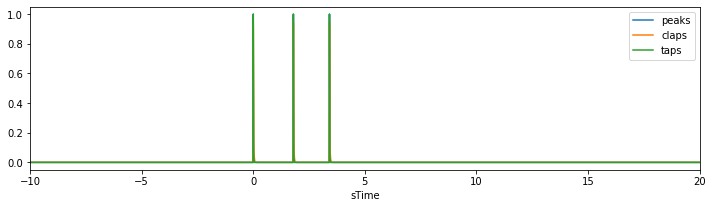

In [70]:
CueT={}
sf = 256
t_range= [-10,20]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240305'] = cue

In [71]:
Sync_Zero_Time_dt

Timestamp('2024-03-05 07:42:22.272471655')

In [72]:
cue_times = pd.read_csv('./outfiles/cue2_20240305.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue2_20240305'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

22245.859163    22237.5867
22248.155036    22239.8825
22250.323200    22242.0507
Name: SyncTime, dtype: float64

In [73]:
cue_times

,rms,peaks,DateTime,S_AudioTime,SyncTime
22244.971000,0.000078,0,2024-03-05 13:52:58.971000+00:00,22244.9710,22236.6985
22244.973902,0.000107,0,2024-03-05 13:52:58.973902494+00:00,22244.9739,22236.7014
22244.976805,0.000134,0,2024-03-05 13:52:58.976804989+00:00,22244.9768,22236.7043
22244.979707,0.000161,0,2024-03-05 13:52:58.979707483+00:00,22244.9797,22236.7072
22244.982610,0.000169,0,2024-03-05 13:52:58.982609977+00:00,22244.9826,22236.7101
...,...,...,...,...,...
22250.958846,0.000282,0,2024-03-05 13:53:04.958845805+00:00,22250.9588,22242.6863
22250.961748,0.000275,0,2024-03-05 13:53:04.961748299+00:00,22250.9617,22242.6892
22250.964651,0.000270,0,2024-03-05 13:53:04.964650794+00:00,22250.9647,22242.6922
22250.967553,0.000206,0,2024-03-05 13:53:04.967553288+00:00,22250.9676,22242.6951


In [74]:
peak_times

22245.859163    22237.5867
22248.155036    22239.8825
22250.323200    22242.0507
Name: SyncTime, dtype: float64

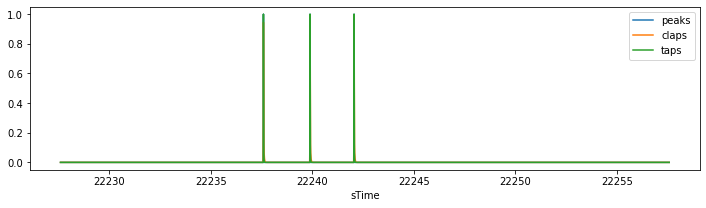

In [75]:
cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue2_20240305'] = cue

In [76]:
cue_times = pd.read_csv('./outfiles/cue3_20240305.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue3_20240305'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

28080.852841    28072.5803
28082.719145    28074.4466
28084.478057    28076.2056
Name: SyncTime, dtype: float64

In [77]:
cue_times

,rms,peaks,DateTime,S_AudioTime,SyncTime
28078.943000,0.000738,0,2024-03-05 15:30:12.943000+00:00,28078.9430,28070.6705
28078.945902,0.001066,0,2024-03-05 15:30:12.945902494+00:00,28078.9459,28070.6734
28078.948805,0.001135,0,2024-03-05 15:30:12.948804989+00:00,28078.9488,28070.6763
28078.951707,0.001135,0,2024-03-05 15:30:12.951707483+00:00,28078.9517,28070.6792
28078.954610,0.001138,0,2024-03-05 15:30:12.954609977+00:00,28078.9546,28070.6821
...,...,...,...,...,...
28084.930846,0.000173,0,2024-03-05 15:30:18.930845805+00:00,28084.9308,28076.6583
28084.933748,0.000137,0,2024-03-05 15:30:18.933748299+00:00,28084.9337,28076.6612
28084.936651,0.000095,0,2024-03-05 15:30:18.936650794+00:00,28084.9367,28076.6642
28084.939553,0.000084,0,2024-03-05 15:30:18.939553288+00:00,28084.9396,28076.6671


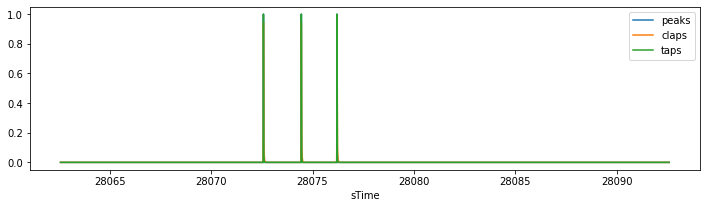

In [78]:
cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue3_20240305'] = cue

In [127]:
cue_times = pd.read_csv('./outfiles/cue1_20240304.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue1_20240304'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

285.762812    277.4903
287.225669    278.9532
288.665306    280.3928
Name: SyncTime, dtype: float64

In [130]:
t_range

[-10.0, 19.99609375]

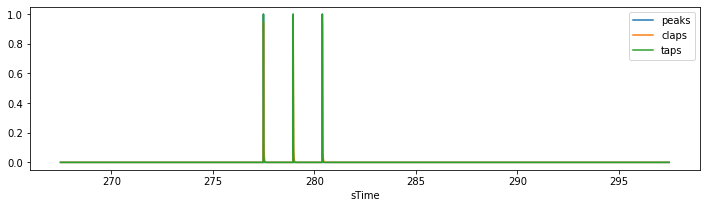

In [131]:
t_range= [-10,20]

cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue1_20240304'] = cue

In [132]:
synch_times

{'cue1_20240305': Timestamp('2024-03-05 07:42:22.272471655'),
 'cue2_20240305': Timestamp('2024-03-05 13:52:59.859163265'),
 'cue3_20240305': Timestamp('2024-03-05 15:30:14.852841270'),
 'cue1_20240304': Timestamp('2024-03-04 07:56:23.762811791')}

In [133]:
CueT

{'cue1_20240305':           sTime  peaks           taps  claps
 0    -10.000000      0   0.000000e+00    0.0
 1     -9.996094      0   0.000000e+00    0.0
 2     -9.992188      0   0.000000e+00    0.0
 3     -9.988281      0   0.000000e+00    0.0
 4     -9.984375      0   0.000000e+00    0.0
 ...         ...    ...            ...    ...
 7675  19.980469      0  9.881313e-324    0.0
 7676  19.984375      0  9.881313e-324    0.0
 7677  19.988281      0  9.881313e-324    0.0
 7678  19.992188      0   0.000000e+00    0.0
 7679  19.996094      0   0.000000e+00    0.0
 
 [7680 rows x 4 columns],
 'cue2_20240305':              sTime  peaks           taps  claps
 0     22227.586700      0   0.000000e+00    0.0
 1     22227.590606      0   0.000000e+00    0.0
 2     22227.594512      0   0.000000e+00    0.0
 3     22227.598419      0   0.000000e+00    0.0
 4     22227.602325      0   0.000000e+00    0.0
 ...            ...    ...            ...    ...
 7675  22257.567169      0  9.881313e-324  

## Load example of ACC data

In [81]:
# note special complications: VN104 was not returned on march 04, recorded through to late on march 05
# LS404 was also late on March 05. These need to be synched with Synch 3. 

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [82]:
data_dir='/Volumes/Seagatehub/BiC2024/20240305/Equivital/Extracted SEM Data/'
# data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='PC710'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             5022204
Date                                                            240305
Session                                                            101
FileName                             DATA-PC710-5022204-24030500_0.CSV
FileType                                                           csv
FileSize                                                        129335
RecStart                                     2024-03-05 07:36:01+00:00
RecEnd                                       2024-03-05 13:54:31+00:00
Duration                                                       22710.0
BatteryStart                                                      4147
BatteryEnd                                                        4018
BatteryChange(mV)                                                 -129
FullLoc              /Volumes/Seagatehub/BiC2024/20240305/Equivital...
DATAlo

In [83]:
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN104,DATA,3420456,240304,101,DATA-VN104-3420456-24030400_0.CSV,csv,644696,2024-03-04 07:33:10+00:00,2024-03-05 15:30:25+00:00,115035.0,...,[VN104],3420456.0,VN104,53.0,4,100.0,0.0,1.0,Stationary,Supine
VN109,DATA,5022010,240305,101,DATA-VN109-5022010-24030500_0.CSV,csv,135078,2024-03-05 07:16:27+00:00,2024-03-05 13:55:12+00:00,23925.0,...,[VN109],5022010.0,VN109,53.0,84,98.0,0.0,0.0,Stationary,Upright
VN110,DATA,5022026,240305,0,DATA-VN110-5022026-24030500.CSV,csv,134591,2024-03-05 07:16:29+00:00,2024-03-05 13:53:59+00:00,23850.0,...,[VN110],5022026.0,VN110,53.0,81,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240305,101,DATA-VN111-5022027-24030500_0.CSV,csv,134993,2024-03-05 07:16:32+00:00,2024-03-05 13:55:47+00:00,23955.0,...,[VN111],5022027.0,VN111,53.0,74,97.0,0.0,1.0,Stationary,Upright
VN201,DATA,5022050,240305,101,DATA-VN201-5022050-24030500_0.CSV,csv,134530,2024-03-05 07:16:34+00:00,2024-03-05 13:54:19+00:00,23865.0,...,[VN201],5022050.0,VN201,53.0,62,98.0,0.0,0.0,Stationary,Upright
VN101,DATA,3420415,240305,101,DATA-VN101-3420415-24030500_0.CSV,csv,135328,2024-03-05 07:18:17+00:00,2024-03-05 13:55:32+00:00,23835.0,...,[VN101],3420415.0,VN101,53.0,0,98.0,0.0,1.0,MovingSlowly,Upright
VN105,DATA,3420755,240305,0,DATA-VN105-3420755-24030500.CSV,csv,133501,2024-03-05 07:18:23+00:00,2024-03-05 13:55:23+00:00,23820.0,...,[VN105],3420755.0,VN105,53.0,0,100.0,0.0,1.0,Stationary,Prone
VN212,DATA,5022256,240305,101,DATA-VN212-5022256-24030500_0.CSV,csv,132100,2024-03-05 07:18:52+00:00,2024-03-05 13:55:52+00:00,23820.0,...,[VN212],5022256.0,VN212,53.0,0,100.0,1.0,1.0,Stationary,Side
VA304,DATA,5022110,240305,0,DATA-VA304-5022110-24030500.CSV,csv,133645,2024-03-05 07:19:51+00:00,2024-03-05 13:55:06+00:00,23715.0,...,[VA304],5022110.0,VA304,53.0,64,98.0,0.0,1.0,Stationary,Upright


In [84]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-05 07:35:33.007,0.0
1,2024-03-05 07:35:33.011,0.0
2,2024-03-05 07:35:33.015,0.0
3,2024-03-05 07:35:33.019,0.0
4,2024-03-05 07:35:33.023,0.0
5,2024-03-05 07:35:33.027,0.0


In [192]:
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-04 07:32:42.007,0.0
1,2024-03-04 07:32:42.011,0.0
2,2024-03-04 07:32:42.015,0.0
3,2024-03-04 07:32:42.019,0.0
4,2024-03-04 07:32:42.023,0.0
5,2024-03-04 07:32:42.027,0.0


In [193]:
c = 'cue1_20240304'

In [194]:
synch_times[c]

Timestamp('2024-03-04 07:56:23.762811791')

15360


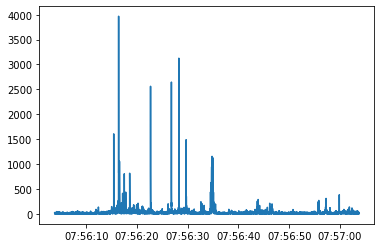

In [195]:
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

Cues offset by about 14 s

In [209]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240304'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(-275,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-04 07:51:48.762811791


,sTime,peaks,taps,claps
0,267.490300,0,0.000000e+00,0.0
1,267.494206,0,0.000000e+00,0.0
2,267.498113,0,0.000000e+00,0.0
3,267.502019,0,0.000000e+00,0.0
4,267.505925,0,0.000000e+00,0.0
...,...,...,...,...
7675,297.470769,0,9.881313e-324,0.0
7676,297.474675,0,9.881313e-324,0.0
7677,297.478581,0,9.881313e-324,0.0
7678,297.482488,0,0.000000e+00,0.0


In [210]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
print(t_range)
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

[267.49030000000005, 297.48639375000005]


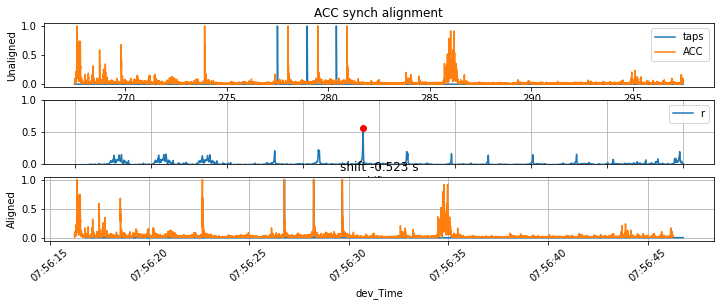

2024-03-04 07:56:26.776549291


In [211]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

In [212]:
synch_times[c]

Timestamp('2024-03-04 07:56:23.762811791')

In [92]:
ACC.iloc[-5:,:]

,dev_dTime,signal
5823444,2024-03-05 13:54:39.847,67.424031
5823445,2024-03-05 13:54:39.851,469.771221
5823446,2024-03-05 13:54:39.855,419.505661
5823447,2024-03-05 13:54:39.859,249.473445
5823448,2024-03-05 13:54:39.863,319.951559


In [93]:
dt_0 

Timestamp('2024-03-05 07:42:02.272471655')

In [94]:
CueT[c]

,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [95]:
synch_times['cue2_20240305']

Timestamp('2024-03-05 13:52:59.859163265')

In [96]:
ACC_ex

,dev_dTime,signal
99905,2024-03-05 07:42:02.273,85.381497
99906,2024-03-05 07:42:02.277,61.595454
99907,2024-03-05 07:42:02.281,70.753092
99908,2024-03-05 07:42:02.285,148.371156
99909,2024-03-05 07:42:02.289,123.616342
...,...,...
115260,2024-03-05 07:43:02.253,28.861739
115261,2024-03-05 07:43:02.257,114.647285
115262,2024-03-05 07:43:02.261,70.356236
115263,2024-03-05 07:43:02.265,52.706736


In [97]:
c = 'cue2_20240305'
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
ACC_ex

,dev_dTime,signal
5792728,2024-03-05 13:52:39.863,32.756679
5792729,2024-03-05 13:52:39.867,23.345235
5792730,2024-03-05 13:52:39.871,24.657656
5792731,2024-03-05 13:52:39.874,12.649111
5792732,2024-03-05 13:52:39.878,12.649111
...,...,...
5808083,2024-03-05 13:53:39.843,15.779734
5808084,2024-03-05 13:53:39.847,11.704700
5808085,2024-03-05 13:53:39.851,21.000000
5808086,2024-03-05 13:53:39.855,13.266499


In [37]:
CueT[c]

,sTime,peaks,taps,claps
0,22227.586700,0,0.000000e+00,0.0
1,22227.590606,0,0.000000e+00,0.0
2,22227.594512,0,0.000000e+00,0.0
3,22227.598419,0,0.000000e+00,0.0
4,22227.602325,0,0.000000e+00,0.0
...,...,...,...,...
7675,22257.567169,0,9.881313e-324,0.0
7676,22257.571075,0,9.881313e-324,0.0
7677,22257.574981,0,9.881313e-324,0.0
7678,22257.578887,0,0.000000e+00,0.0


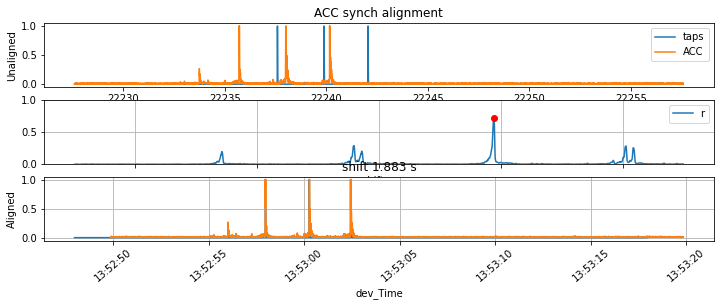

Timestamp('2024-03-05 13:52:57.976359155')

In [100]:
c = 'cue2_20240305'
results = min_align(ACC,CueT[c].copy(),synch_times['cue1_20240305'].tz_localize(None),10)
results['best_dt']

# Running through the sensors

In [102]:
data_dir='/Volumes/Seagatehub/BiC2024/20240305/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN104,DATA,3420456,240304,101,DATA-VN104-3420456-24030400_0.CSV,csv,644696,2024-03-04 07:33:10+00:00,2024-03-05 15:30:25+00:00,115035.0,...,[VN104],3420456.0,VN104,53.0,4,100.0,0.0,1.0,Stationary,Supine
VN109,DATA,5022010,240305,101,DATA-VN109-5022010-24030500_0.CSV,csv,135078,2024-03-05 07:16:27+00:00,2024-03-05 13:55:12+00:00,23925.0,...,[VN109],5022010.0,VN109,53.0,84,98.0,0.0,0.0,Stationary,Upright
VN110,DATA,5022026,240305,0,DATA-VN110-5022026-24030500.CSV,csv,134591,2024-03-05 07:16:29+00:00,2024-03-05 13:53:59+00:00,23850.0,...,[VN110],5022026.0,VN110,53.0,81,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240305,101,DATA-VN111-5022027-24030500_0.CSV,csv,134993,2024-03-05 07:16:32+00:00,2024-03-05 13:55:47+00:00,23955.0,...,[VN111],5022027.0,VN111,53.0,74,97.0,0.0,1.0,Stationary,Upright
VN201,DATA,5022050,240305,101,DATA-VN201-5022050-24030500_0.CSV,csv,134530,2024-03-05 07:16:34+00:00,2024-03-05 13:54:19+00:00,23865.0,...,[VN201],5022050.0,VN201,53.0,62,98.0,0.0,0.0,Stationary,Upright


['VN109', 22.903098106384277]


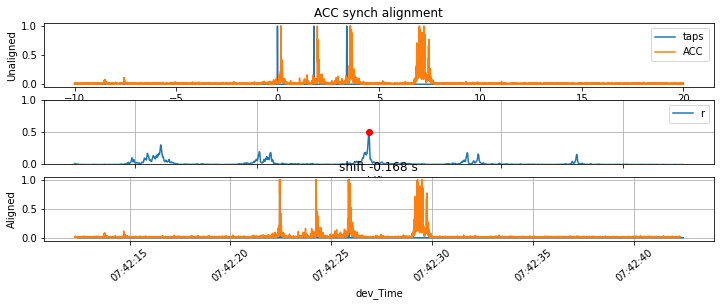

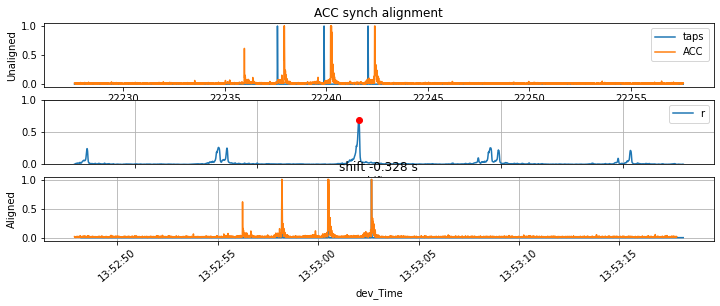

['VN110', 49.0948588848114]


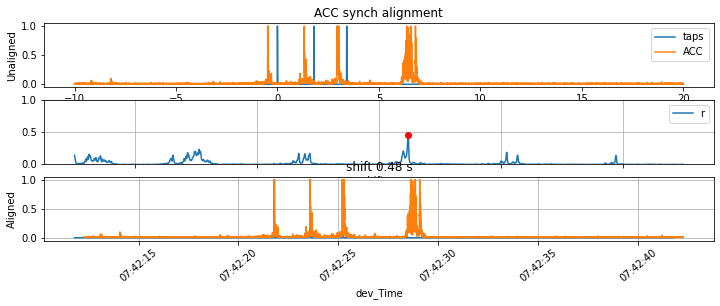

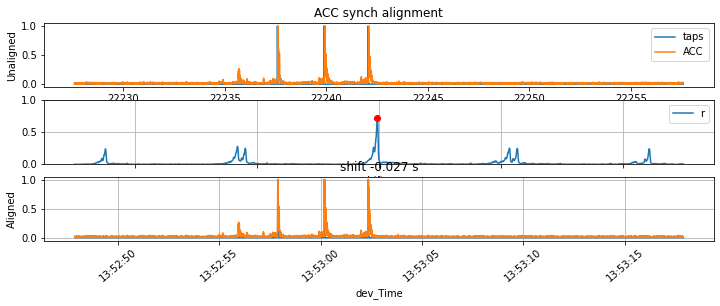

['VN111', 76.11889100074768]


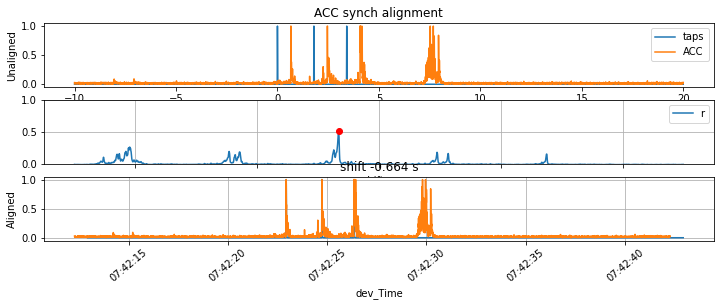

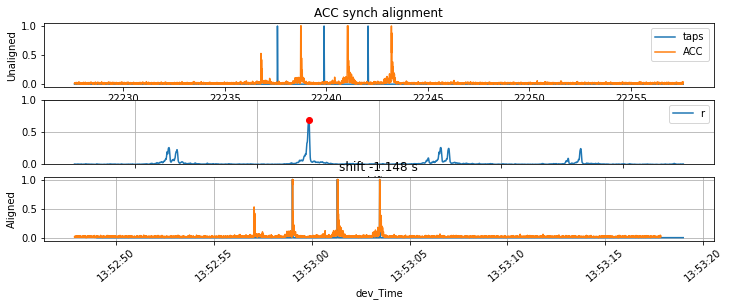

['VN201', 102.39127707481384]


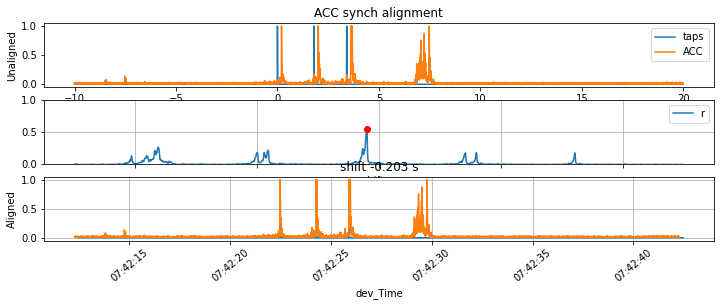

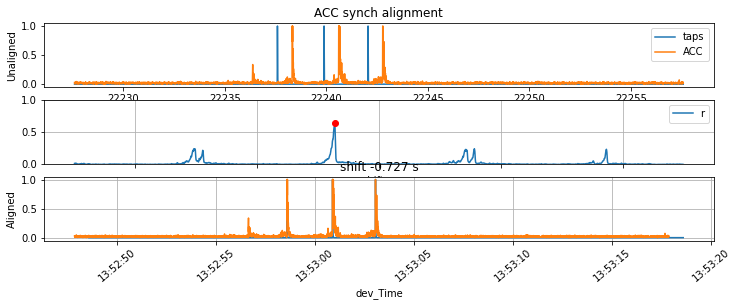

['VN101', 127.38944292068481]


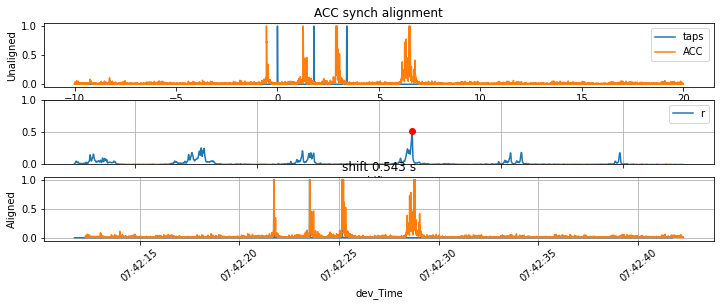

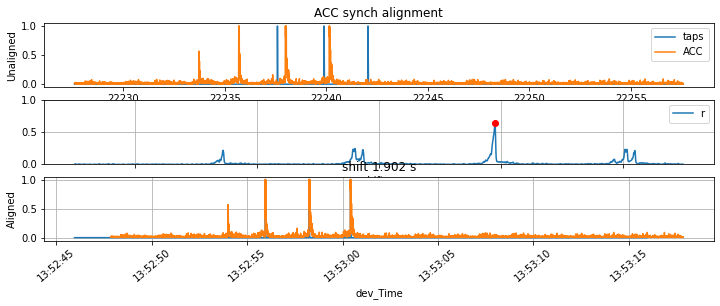

['VN105', 152.13520908355713]


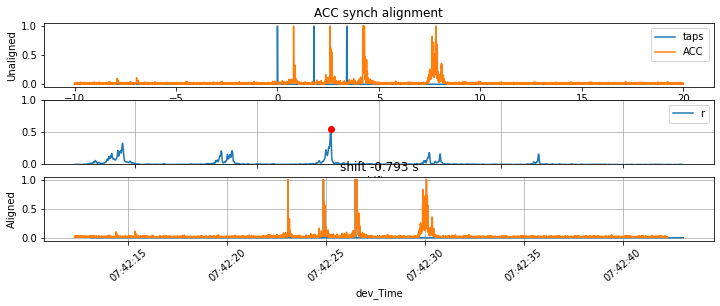

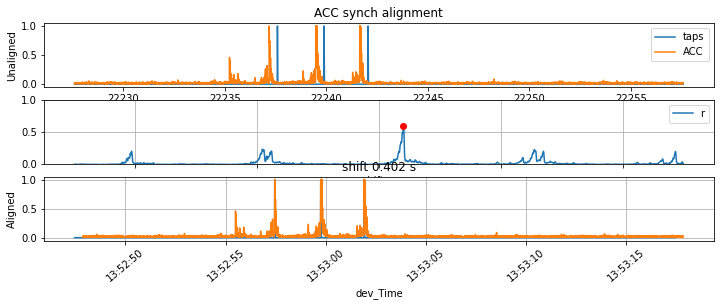

['VN212', 176.5145299434662]


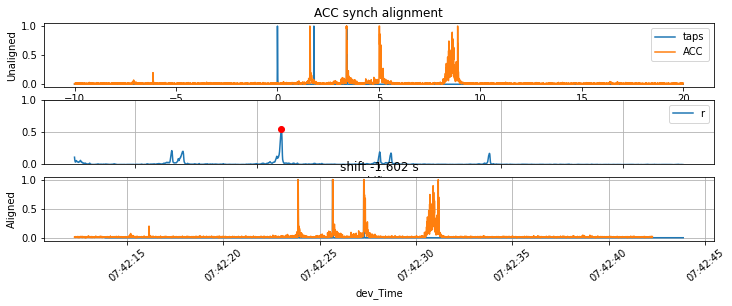

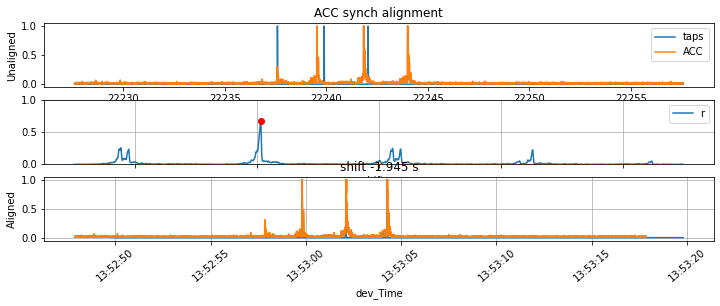

['VA304', 200.79482698440552]


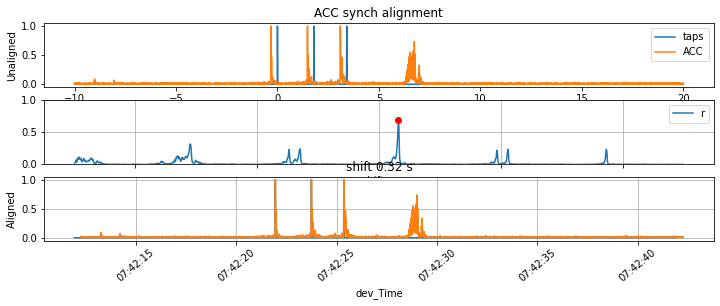

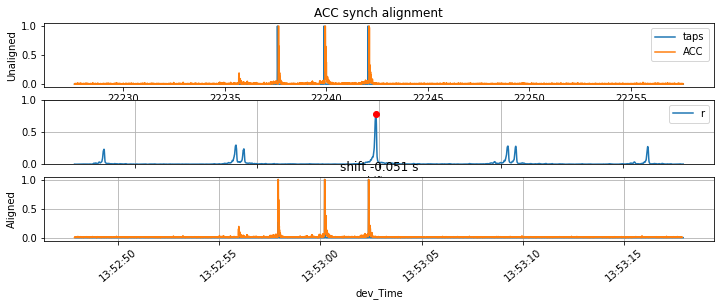

['VA305', 225.30089902877808]


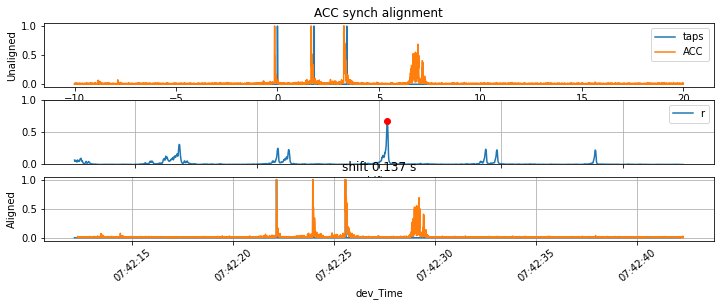

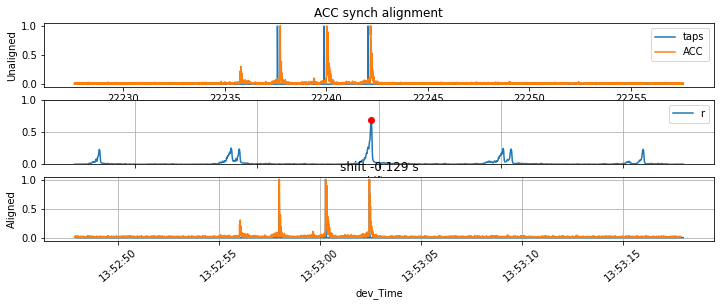

['VA309', 249.53110313415527]


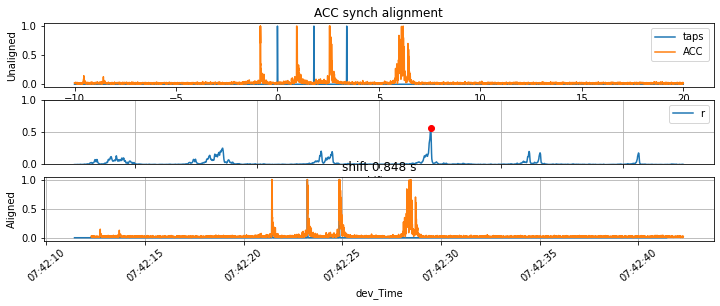

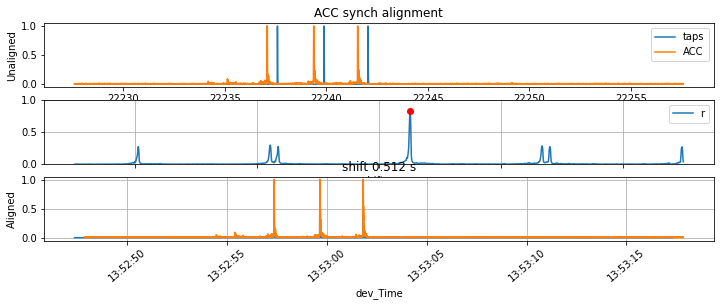

['LS401', 273.8072192668915]


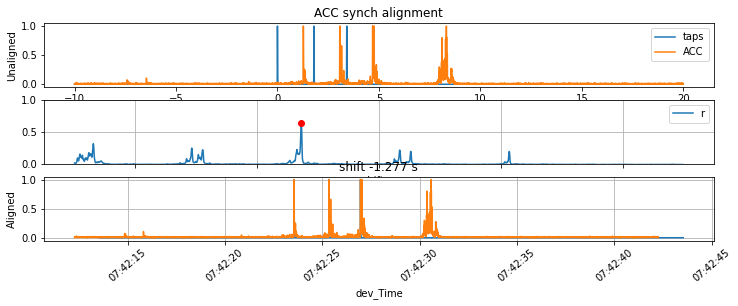

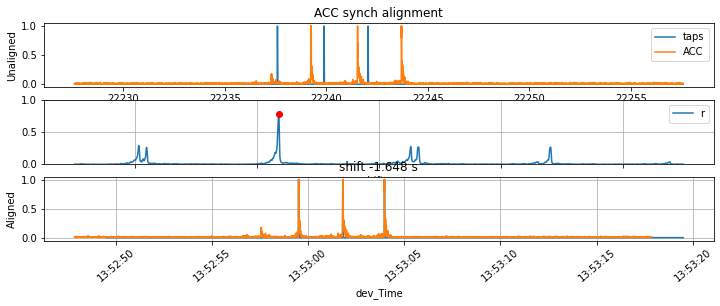

['VN211', 298.30909419059753]


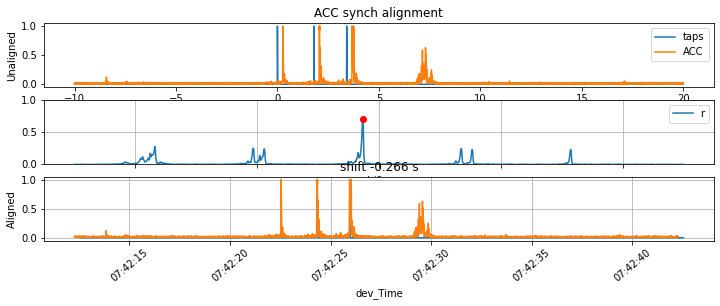

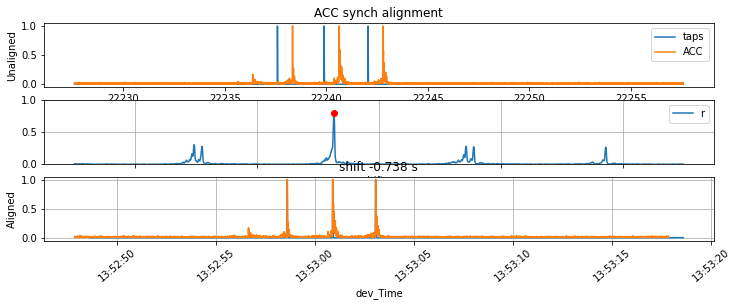

['LS407', 322.22351813316345]


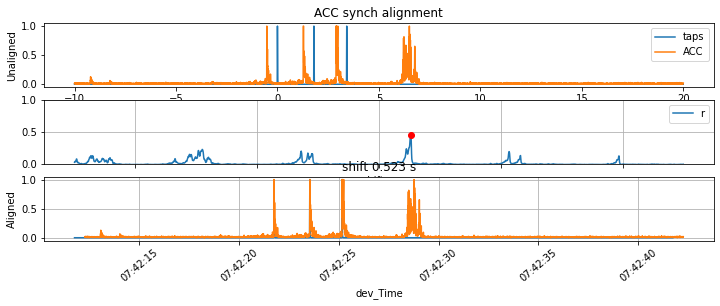

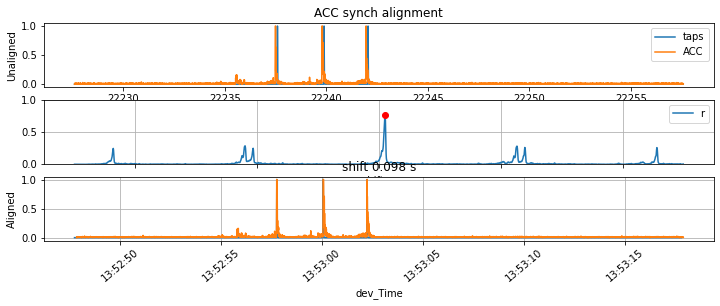

['LS410', 346.0831310749054]


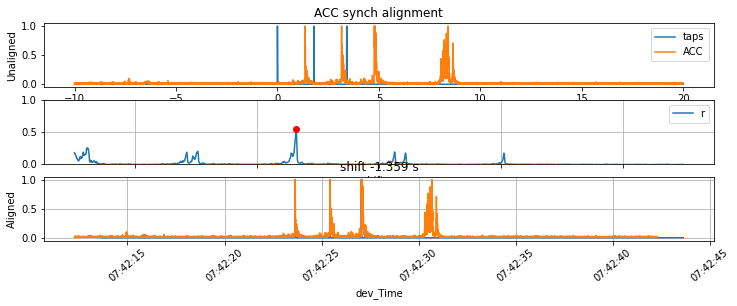

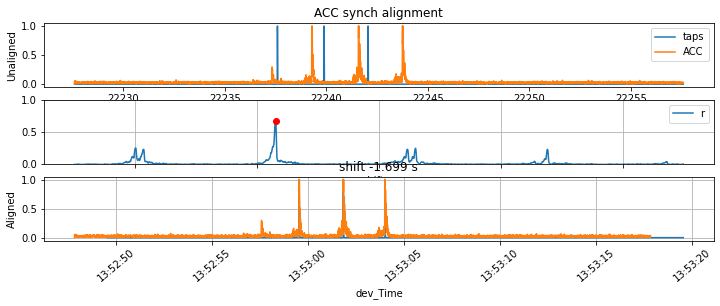

['WW504', 369.77447414398193]


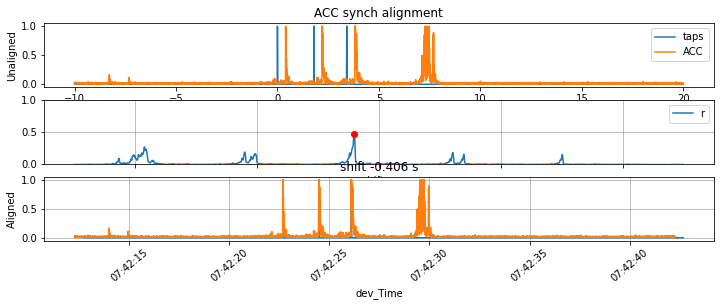

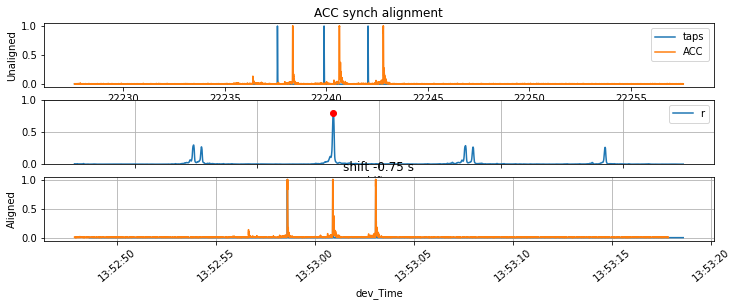

['WW506', 393.341304063797]


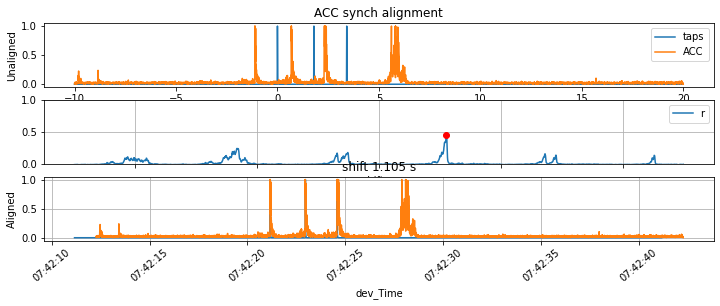

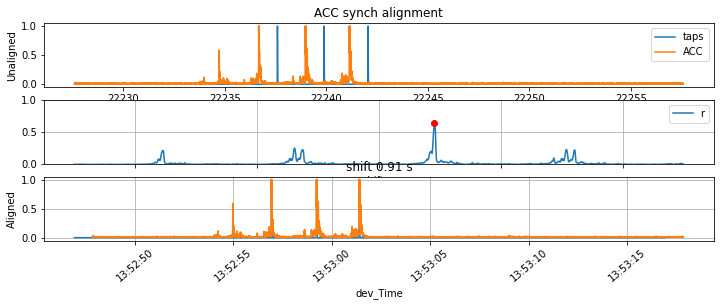

['WW508', 417.1370348930359]


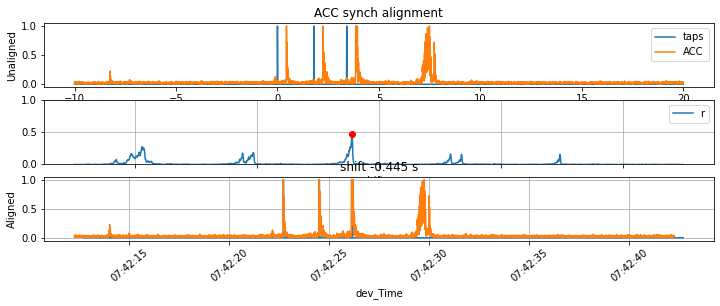

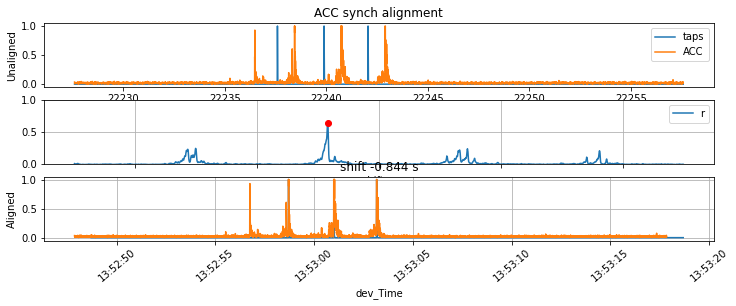

['VN206', 440.8918240070343]


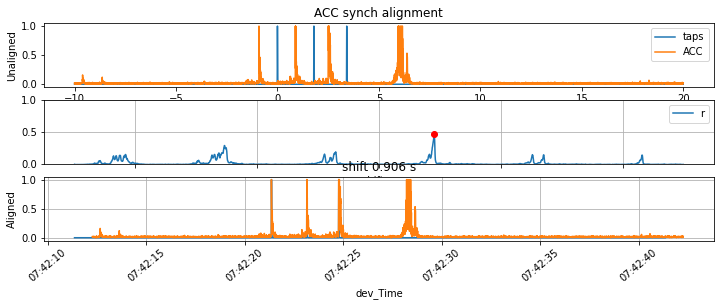

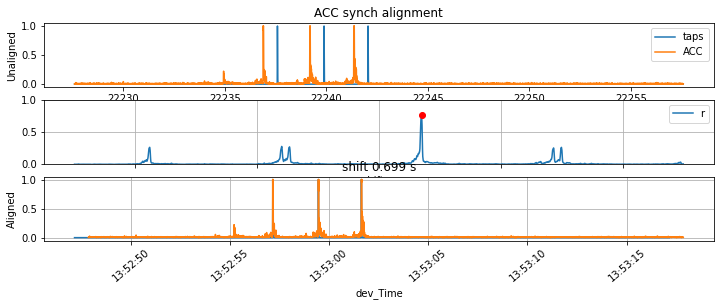

['LS402', 464.7991180419922]


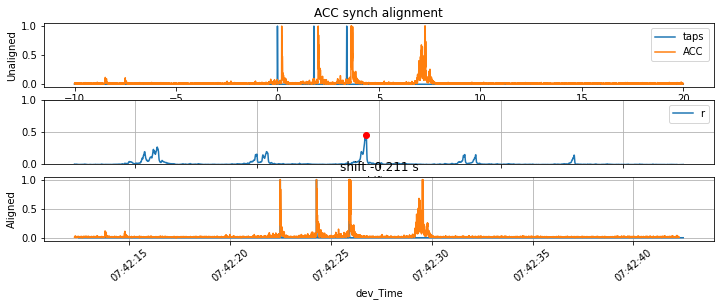

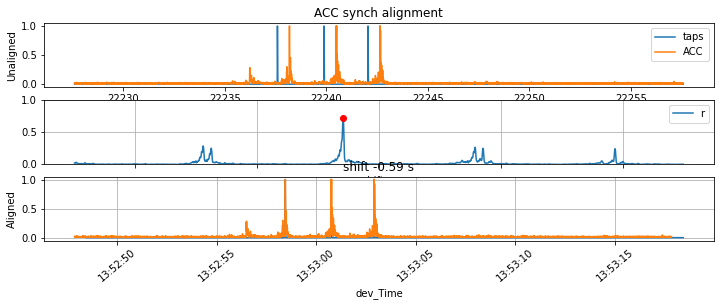

['BR605', 488.9302101135254]


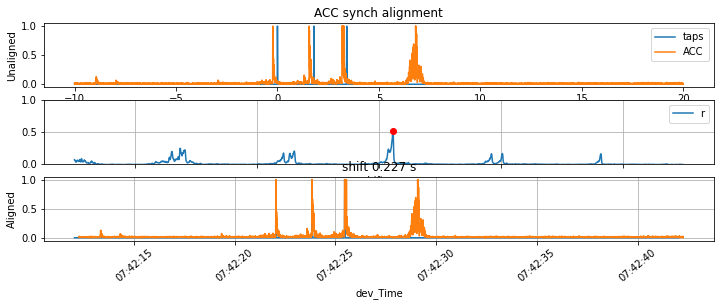

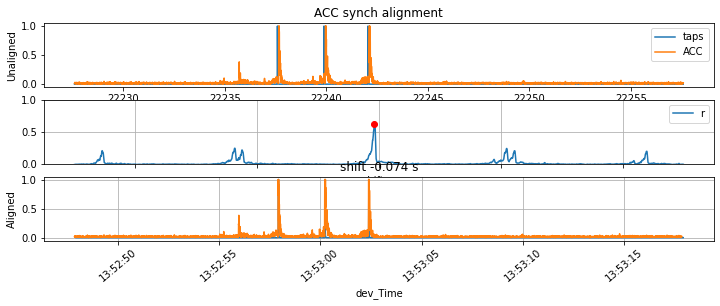

['BR604', 512.5901520252228]


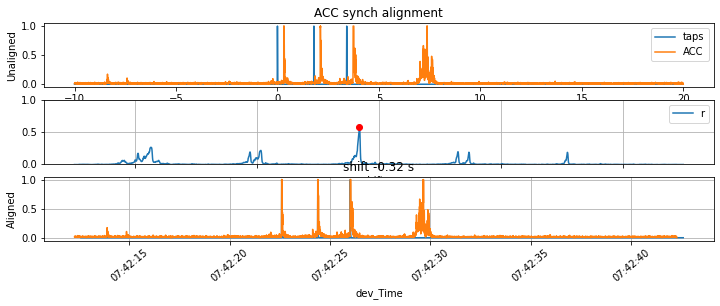

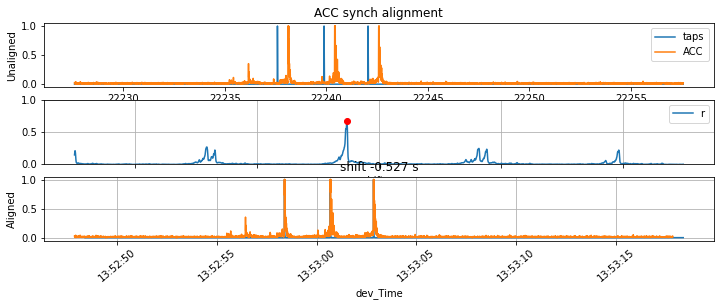

['BR606', 536.7653448581696]


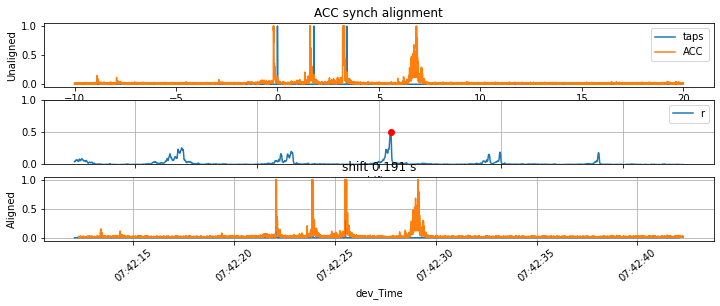

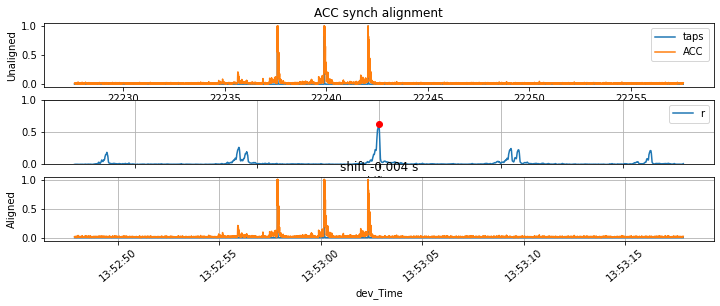

['BR608', 560.3823041915894]


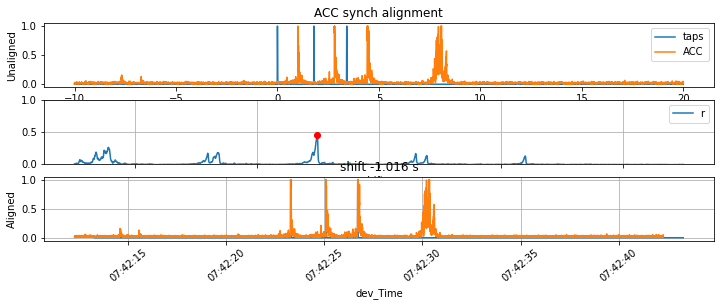

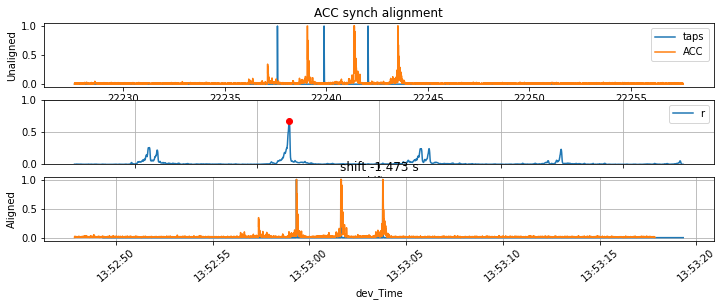

['BR609', 584.3189642429352]


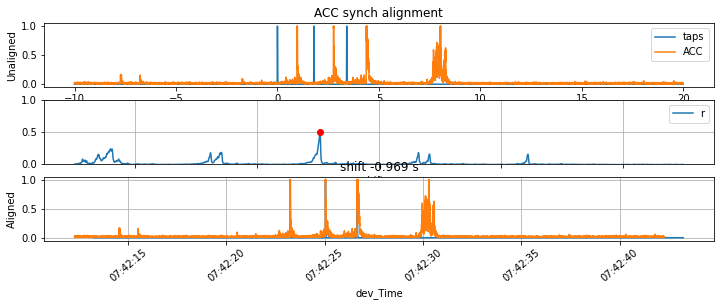

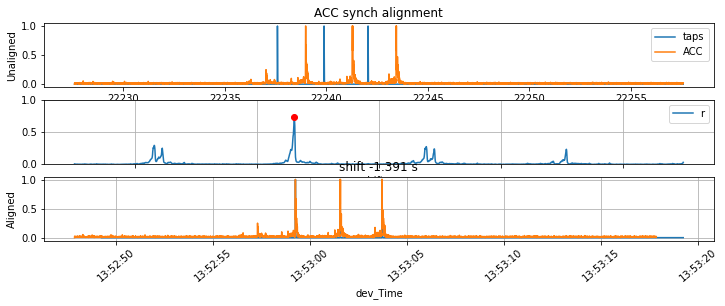

['PC702', 608.7959740161896]


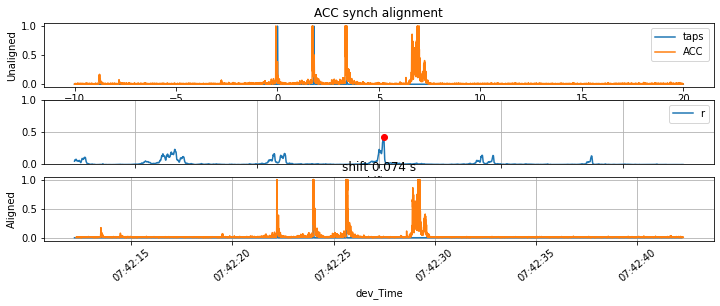

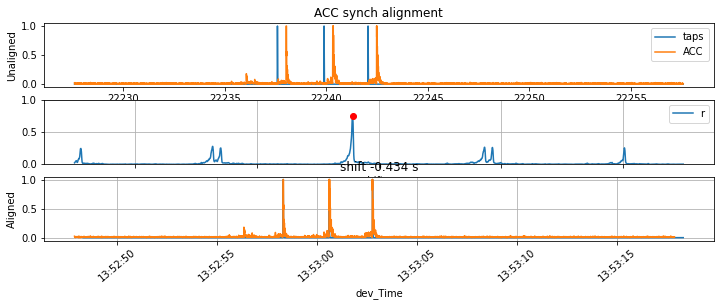

['PC710', 633.1951739788055]


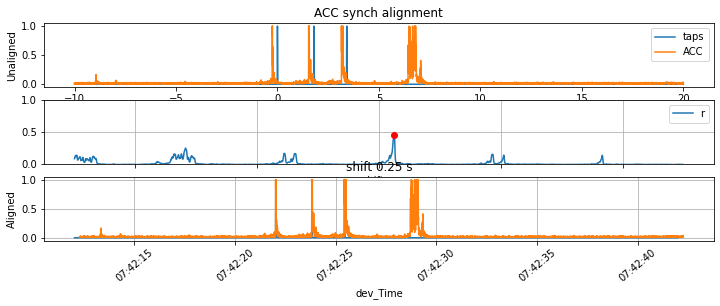

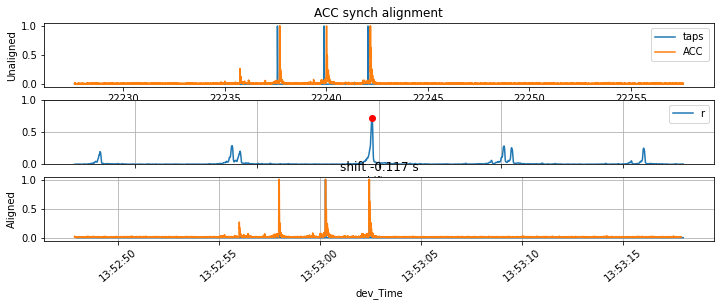

['PC709', 657.5893301963806]


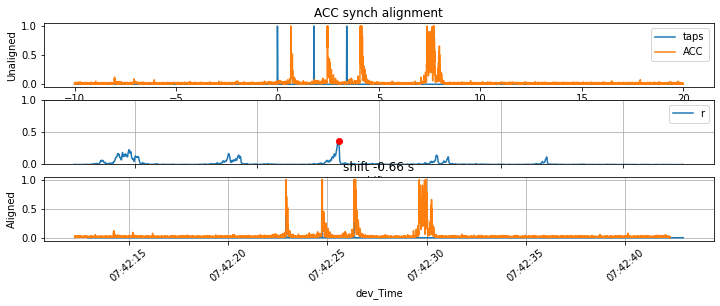

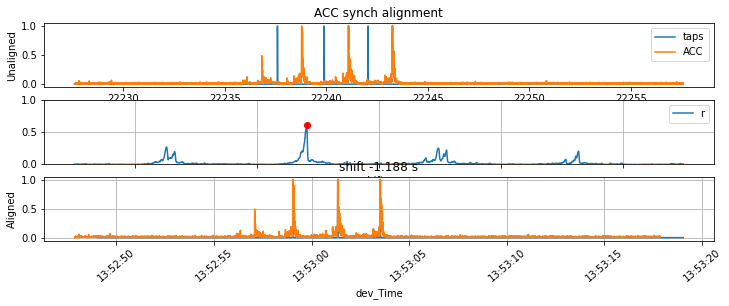

['LS405', 681.8296859264374]


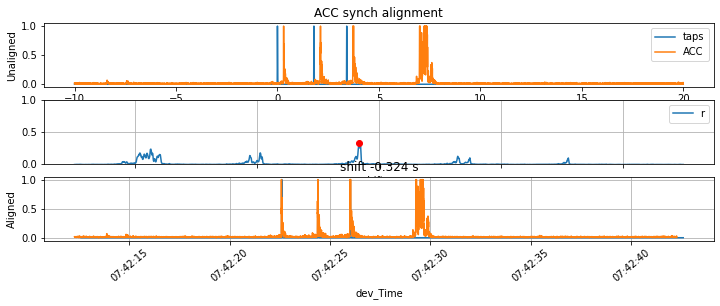

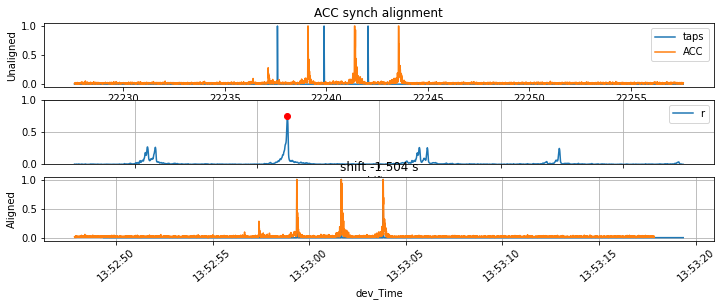

684.2842020988464


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r
DevName,,,,,,
VN104,NaN,NaN,NaN,NaN,NaN,NaN
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027


In [105]:
df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = 0
t_drift = 2

for pid,row in df_datafiles.iterrows():
    if pid not in ['VN104','LS404']:
        V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
        ACC = pd.DataFrame()
        ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
        ACC = remove_tz_from_dataframe(ACC)
        print([pid,time.time()-tic])

        dt_0 = synch_times['cue1_20240305']-pd.to_timedelta(20,unit='s')
        dt_1 = synch_times['cue1_20240305']+pd.to_timedelta(20,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 5
        results = min_align(ACC_ex,CueT['cue1_20240305'].copy(),(synch_times['cue1_20240305']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue1_s'] = results['best_s']
        df_shifts.loc[pid,'Cue1_r'] = results['best_r']

        dt_0 = synch_times['cue2_20240305']-pd.to_timedelta(20,unit='s')
        dt_1 = synch_times['cue2_20240305']+pd.to_timedelta(20,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 10
        results = min_align(ACC_ex,CueT['cue2_20240305'].copy(),(synch_times['cue1_20240305']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
        df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [106]:
[df_shifts['Cue1_s'].mean(),df_shifts['Cue2_s'].mean()]

[-0.18136160714285715, 1.5424107142857142]

In [107]:
df_shifts['dur_dt']=pd.to_datetime(df_shifts['Cue2_devdTime'])-pd.to_datetime(df_shifts['Cue1_devdTime'])
df_shifts['dur_s']=df_shifts['dur_dt'].dt.total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')

In [109]:
(synch_times['cue2_20240305']-synch_times['cue1_20240305']).total_seconds()

22237.586691

In [115]:
df_shifts['devID'] = df_datafiles['ID']

In [118]:
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID
DevName,,,,,,,,,,,
VN104,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,3420456
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110


In [119]:
cues_delta = (synch_times['cue2_20240305']-synch_times['cue1_20240305']).total_seconds()
df_shifts['drift_s'] = df_shifts['dur_s']-cues_delta 
df_shifts['drift_rate_sphr']=(df_shifts['drift_s'])/(cues_delta/3600)
# drifted seconds per hour
df_shifts['drift_rate_sphr']

DevName
VN104         NaN
VN109   -0.297847
VN110   -0.241566
VN111   -0.245360
VN201   -0.239036
VN101   -0.543841
VN105   -0.517282
VN212   -0.268126
VA304   -0.263699
VA305   -0.280773
VA309   -0.269390
LS401   -0.263699
VN211   -0.247257
LS407   -0.254846
LS410   -0.268758
WW504   -0.268126
WW506   -0.292156
WW508   -0.259272
VN206   -0.290259
LS402   -0.262434
LS404         NaN
BR605   -0.275082
BR604   -0.290259
BR606   -0.292156
BR608   -0.249787
BR609   -0.255478
PC702   -0.241566
PC710   -0.264331
PC709   -0.238404
LS405   -0.132797
Name: drift_rate_sphr, dtype: float64

In [254]:
df_shifts.to_csv('./outfiles/Cue_dev_align_20240305.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID
DevName,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,1 days 07:33:32.892628614,113612.892628,-18.197401,-0.576520,3420456
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110


Clean up LS404 and VN104 

['LS404', 29.62366795539856]


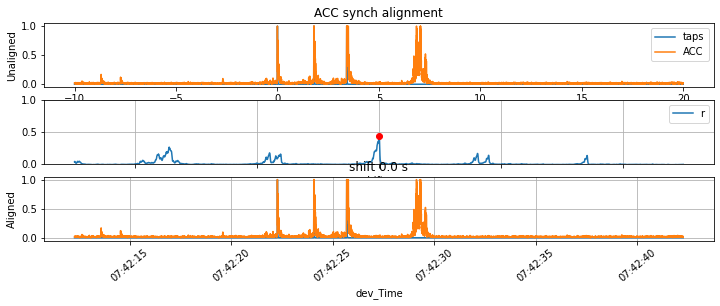

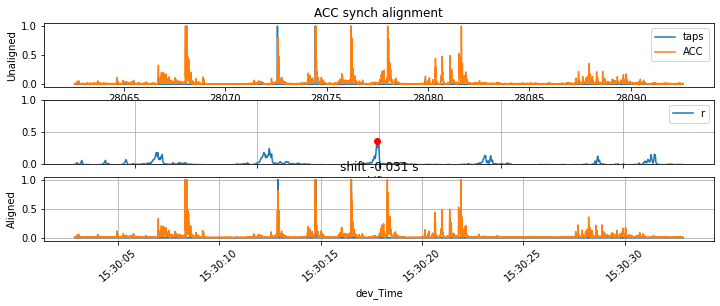

32.013312101364136


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID
DevName,,,,,,,,,,,
VN104,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,3420456
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110


In [124]:
# df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = 0
t_drift = 2
pid = 'LS404'
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
print([pid,time.time()-tic])

dt_0 = synch_times['cue1_20240305']-pd.to_timedelta(20,unit='s')
dt_1 = synch_times['cue1_20240305']+pd.to_timedelta(20,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
maxlag_s = 5
results = min_align(ACC_ex,CueT['cue1_20240305'].copy(),(synch_times['cue1_20240305']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
df_shifts.loc[pid,'Cue1_s'] = results['best_s']
df_shifts.loc[pid,'Cue1_r'] = results['best_r']

dt_0 = synch_times['cue3_20240305']-pd.to_timedelta(20,unit='s')
dt_1 = synch_times['cue3_20240305']+pd.to_timedelta(20,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
maxlag_s = 10
results = min_align(ACC_ex,CueT['cue3_20240305'].copy(),(synch_times['cue1_20240305']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [125]:
pid

'LS404'

In [126]:
df_shifts.loc[pid,'dur_dt']=pd.to_datetime(df_shifts.loc[pid,'Cue2_devdTime'])-pd.to_datetime(df_shifts.loc[pid,'Cue1_devdTime'])
df_shifts.loc[pid,'dur_s']=df_shifts.loc[pid,'dur_dt'].total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cues_delta = (synch_times['cue3_20240305']-synch_times['cue1_20240305']).total_seconds()
df_shifts.loc[pid,'drift_s'] = df_shifts.loc[pid,'dur_s']-cues_delta 
df_shifts.loc[pid,'drift_rate_sphr']=(df_shifts.loc[pid,'drift_s'])/(cues_delta/3600)
# drifted seconds per hour
# df_shifts['drift_rate_sphr']
df_shifts.loc[pid,:]

Cue1_devdTime      2024-03-05 07:42:22.272471655
Cue1_s                                       0.0
Cue1_r                                  0.443359
Cue2_devdTime      2024-03-05 15:30:12.884021655
Cue2_s                                   1.96875
Cue2_r                                  0.359012
dur_dt                    0 days 07:47:50.611550
dur_s                                28070.61155
drift_s                                -1.968819
drift_rate_sphr                        -0.252479
devID                                    5022142
Name: LS404, dtype: object

In [ ]:
# df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()

pid = 'VN104'
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
print([pid,time.time()-tic])


In [139]:
ACC_ex

,dev_dTime,signal
358847,2024-03-04 07:56:03.765,20.000000
358848,2024-03-04 07:56:03.769,17.435596
358849,2024-03-04 07:56:03.773,9.797959
358850,2024-03-04 07:56:03.777,19.824228
358851,2024-03-04 07:56:03.781,28.722813
...,...,...
369082,2024-03-04 07:56:43.746,36.891733
369083,2024-03-04 07:56:43.749,14.966630
369084,2024-03-04 07:56:43.753,37.854986
369085,2024-03-04 07:56:43.757,8.062258


In [140]:
CueT['cue1_20240304']

,sTime,peaks,taps,claps
0,267.490300,0,0.000000e+00,0.0
1,267.494206,0,0.000000e+00,0.0
2,267.498113,0,0.000000e+00,0.0
3,267.502019,0,0.000000e+00,0.0
4,267.505925,0,0.000000e+00,0.0
...,...,...,...,...
7675,297.470769,0,9.881313e-324,0.0
7676,297.474675,0,9.881313e-324,0.0
7677,297.478581,0,9.881313e-324,0.0
7678,297.482488,0,0.000000e+00,0.0


In [ ]:
al.dt_cut(ACC_ex,'dev_dTime',xrange[0],xrange[1])

In [143]:
(synch_times['cue1_20240304']+pd.to_timedelta(t_center,unit='s')).tz_localize(None)

Timestamp('2024-03-04 07:56:13.762811791')

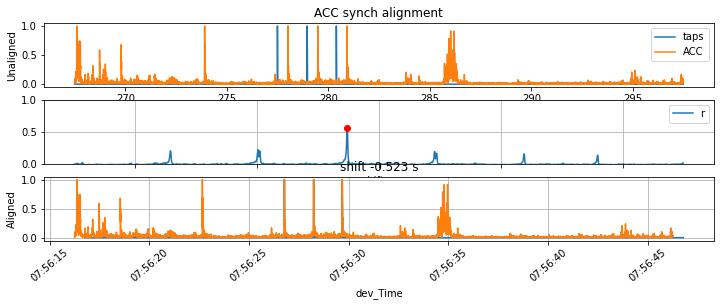

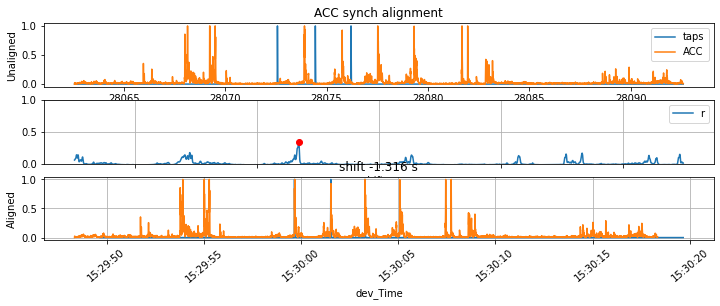

3861.7230417728424


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID
DevName,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,NaT,NaN,NaN,NaN,3420456
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110


In [251]:
t_center = 0
t_drift = 25
dt_0 = synch_times['cue1_20240304']-pd.to_timedelta(10,unit='s')
dt_1 = synch_times['cue1_20240304']+pd.to_timedelta(30,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
maxlag_s = 5
prelim_synch_time = (synch_times['cue1_20240304']+pd.to_timedelta(-275,unit='s')+pd.to_timedelta(t_center,unit='s')).tz_localize(None)
results = min_align(ACC_ex,CueT['cue1_20240304'].copy(),prelim_synch_time.tz_localize(None),maxlag_s)

df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
df_shifts.loc[pid,'Cue1_s'] = results['best_s']
df_shifts.loc[pid,'Cue1_r'] = results['best_r']

dt_0 = synch_times['cue3_20240305']-pd.to_timedelta(30,unit='s')
dt_1 = synch_times['cue3_20240305']+pd.to_timedelta(10,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
maxlag_s = 10
prelim_synch_time = (synch_times['cue1_20240305']+pd.to_timedelta(8.5,unit='s')+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None)
results = min_align(ACC_ex,CueT['cue3_20240305'].copy(),prelim_synch_time.tz_localize(None),maxlag_s)
df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [252]:
pid

'VN104'

In [253]:
df_shifts.loc[pid,'dur_dt']=pd.to_datetime(df_shifts.loc[pid,'Cue2_devdTime'])-pd.to_datetime(df_shifts.loc[pid,'Cue1_devdTime'])
df_shifts.loc[pid,'dur_s']=df_shifts.loc[pid,'dur_dt'].total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cues_delta = (synch_times['cue3_20240305']-synch_times['cue1_20240304']).total_seconds()
df_shifts.loc[pid,'drift_s'] = df_shifts.loc[pid,'dur_s']-cues_delta 
df_shifts.loc[pid,'drift_rate_sphr']=(df_shifts.loc[pid,'drift_s'])/(cues_delta/3600)
# drifted seconds per hour
# df_shifts['drift_rate_sphr']
df_shifts.loc[pid,:]

Cue1_devdTime      2024-03-04 07:56:26.776549291
Cue1_s                                 -0.523438
Cue1_r                                  0.554719
Cue2_devdTime      2024-03-05 15:29:59.669177905
Cue2_s                                 23.683594
Cue2_r                                  0.344493
dur_dt                 1 days 07:33:32.892628614
dur_s                              113612.892628
drift_s                               -18.197401
drift_rate_sphr                         -0.57652
devID                                    3420456
Name: VN104, dtype: object

In [255]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']
df_shifts['Cue1_file'] = './outfiles/cue1_20240305.csv'
df_shifts['Cue1_name'] = 'cue1_20240305'
df_shifts['Cue1_dt'] = synch_times['cue1_20240305']
df_shifts['Cue2_file'] = './outfiles/cue2_20240305.csv'
df_shifts['Cue2_name'] = 'cue2_20240305'
df_shifts['Cue2_dt'] = synch_times['cue2_20240305']
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,1 days 07:33:32.892628614,113612.892628,-18.197401,-0.576520,3420456,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265


In [256]:
pid = 'VN104'
df_shifts.loc[pid,'Cue1_file'] = './outfiles/cue1_20240304.csv'
df_shifts.loc[pid,'Cue1_name'] = 'cue1_20240304'
df_shifts.loc[pid,'Cue1_dt'] = synch_times['cue1_20240304']
df_shifts.loc[pid,'Cue2_file'] = './outfiles/cue23_20240305.csv'
df_shifts.loc[pid,'Cue2_name'] = 'cue3_20240305'
df_shifts.loc[pid,'Cue2_dt'] = synch_times['cue3_20240305']
pid = 'LS404'
df_shifts.loc[pid,'Cue2_file'] = './outfiles/cue23_20240305.csv'
df_shifts.loc[pid,'Cue2_name'] = 'cue3_20240305'
df_shifts.loc[pid,'Cue2_dt'] = synch_times['cue3_20240305']

In [257]:
df_shifts.to_csv('./outfiles/Cue_dev_align_20240305.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,1 days 07:33:32.892628614,113612.892628,-18.197401,-0.576520,3420456,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762811791,./outfiles/cue23_20240305.csv,cue3_20240305,2024-03-05 15:30:14.852841270
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN101,2024-03-05 07:42:21.729502905,0.542969,0.50813,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
